# 📊 Sales Analysis
This notebook analyzes Superstore sales data using Python and Plotly, with a focus on trends in sales, profit, discounts, and shipping performance across regions and product segments.

### 🔹 Step 1: Import Libraries and Load Data
Begin by importing the required libraries and loading the processed Superstore dataset from disk.

In [1]:
import os
import zipfile
import pandas as pd

# Step 1: Get the base directory relative to current script or notebook
base_dir = os.path.dirname(__file__) if '__file__' in globals() else os.getcwd()

# Step 2: Construct path to ZIP file and CSV inside it
zip_path = os.path.join(base_dir, "..", "002_data_raw", "archive.zip")
csv_filename = "Sample - Superstore.csv"

# Step 3: Load the CSV file with encoding handling
try:
    with zipfile.ZipFile(zip_path, 'r') as z:
        with z.open(csv_filename) as f:
            # Try with encoding that prevents misread characters
            df1 = pd.read_csv(f, encoding='latin1')  # or use 'latin1' if needed utf-8-sig
            print("✅ CSV loaded successfully.")
            print(df1.head())
except FileNotFoundError:
    print(f"ZIP file not found: {zip_path}")
except KeyError:
    print(f"{csv_filename} not found inside ZIP archive.")
except Exception as e:
    print(f"Error loading CSV from ZIP: {e}")


✅ CSV loaded successfully.
   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2       3  CA-2016-138688   6/12/2016   6/16/2016    Second Class    DV-13045   
3       4  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
4       5  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID         Category Sub-Categ

### 🔹 Step 2: Data Preparation
Parse date columns and create a new field to enable time-based grouping by month.

In [2]:
import os

# Get the current working directory or script location
base_dir = os.path.dirname(__file__) if '__file__' in globals() else os.getcwd()

# Build path to 004_outputs folder
output_dir = os.path.join(base_dir, "..", "003_data_processed")
os.makedirs(output_dir, exist_ok=True)

# Define output file path
output_file = os.path.join(output_dir, "exported_new_superstore_data.csv")

# Export the DataFrame with encoding that plays nicely with Excel
df1.to_csv(output_file, index=False, encoding='utf-8-sig')
print(f"CSV exported successfully to: {output_file}")


CSV exported successfully to: C:\Users\l_cla\Documents\001_projects\003_project_charlie\001_notebooks\..\003_data_processed\exported_new_superstore_data.csv


### 🔹 Step 3: Monthly Sales and Profit Visualization
This line chart illustrates how sales and profit vary over time, aggregated monthly.

HTML exported successfully to: C:\Users\l_cla\Documents\001_projects\003_project_charlie\001_notebooks\..\004_reports\customer_segments_chart.html


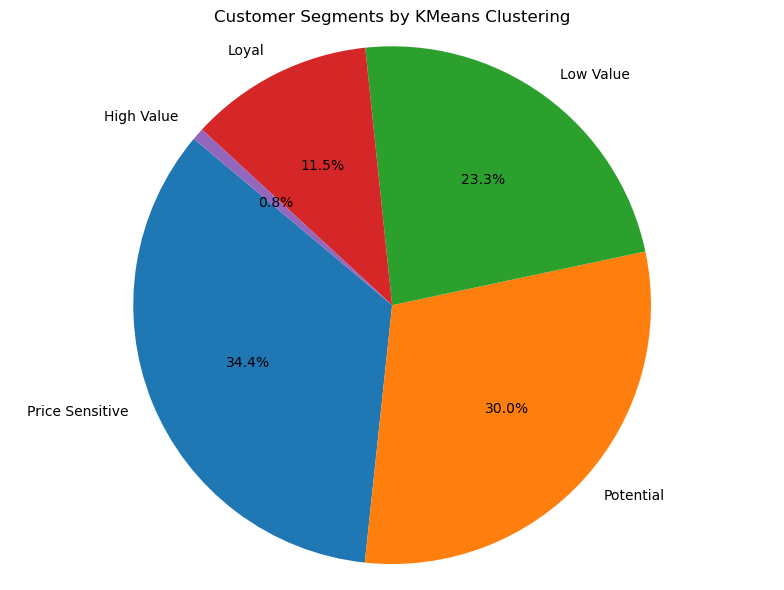

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import os
import base64
from io import BytesIO

# === Step 1: Data Aggregation (same as before) ===
customer_features = df1.groupby("Customer ID").agg({
    "Sales": "sum",
    "Profit": "sum",
    "Discount": "mean",
    "Quantity": "sum",
    "Order ID": "nunique"
}).rename(columns={"Order ID": "Num_Orders"}).reset_index()

# === Step 2: Normalize the features ===
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features.drop("Customer ID", axis=1))

# === Step 3: KMeans clustering ===
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
customer_features['Cluster'] = kmeans.fit_predict(scaled_features)

# === Step 4: Profile and label clusters ===
cluster_profile = customer_features.groupby("Cluster").agg({
    "Sales": "mean",
    "Profit": "mean",
    "Discount": "mean",
    "Quantity": "mean",
    "Num_Orders": "mean"
}).sort_values("Sales", ascending=False)

cluster_labels = {
    cluster_profile.index[0]: "High Value",
    cluster_profile.index[1]: "Loyal",
    cluster_profile.index[2]: "Potential",
    cluster_profile.index[3]: "Price Sensitive",
    cluster_profile.index[4]: "Low Value"
}

customer_features['Segment'] = customer_features['Cluster'].map(cluster_labels)
segment_counts = customer_features['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Customer Count']

# === Plot and save to HTML with embedded image ===
plt.close('all')
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(
    segment_counts['Customer Count'],
    labels=segment_counts['Segment'],
    autopct='%1.1f%%',
    startangle=140
)
ax.set_title('Customer Segments by KMeans Clustering')
plt.axis('equal')
plt.tight_layout()

# Convert to base64 image
buf = BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
img_base64 = base64.b64encode(buf.read()).decode('utf-8')
buf.close()

# Save as HTML
base_dir = os.path.dirname(__file__) if '__file__' in globals() else os.getcwd()
output_dir = os.path.join(base_dir, "..", "004_reports")
os.makedirs(output_dir, exist_ok=True)
output_html = os.path.join(output_dir, "customer_segments_chart.html")

html_content = f"""
<!DOCTYPE html>
<html>
<head>
    <title>Customer Segments</title>
</head>
<body>
    <h2>Customer Segments by KMeans Clustering</h2>
    <img src="data:image/png;base64,{img_base64}" alt="Pie Chart"/>
</body>
</html>
"""

with open(output_html, "w", encoding="utf-8") as f:
    f.write(html_content)

print(f"HTML exported successfully to: {output_html}")


### 🔹 Step 4: Sales and Profit Visualizations by Category, Sub-Category, Region, and Segment
Create a series of charts to explore sales distribution and profitability across different business dimensions.

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from io import BytesIO
import base64

# --- Prepare Time Series Data ---
df1 = df1.reset_index(drop=False)
df1['Order Date'] = pd.to_datetime(df1['Order Date'])
df1.set_index('Order Date', inplace=True)

biweekly_sales = df1['Sales'].resample('2W').sum()
train = biweekly_sales[:-12]
test = biweekly_sales[-12:]
test_index = test.index

# --- Fit Models ---
model_arima = ARIMA(train, order=(1, 0, 1)).fit()
forecast_arima = model_arima.forecast(steps=12)
forecast_arima.index = test_index

model_sarima = SARIMAX(train, order=(1, 0, 1), seasonal_order=(1, 1, 1, 6)).fit()
forecast_sarima = model_sarima.forecast(steps=12)
forecast_sarima.index = test_index

residual_arima = test - forecast_arima
residual_sarima = test - forecast_sarima

# --- Function to convert matplotlib plot to base64 string ---
def fig_to_base64(fig):
    buf = BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    img_base64 = base64.b64encode(buf.read()).decode('utf-8')
    buf.close()
    plt.close(fig)
    return img_base64

# --- Create each plot and convert to base64 ---
# Plot 1: Weekly vs Bi-Weekly
fig1 = plt.figure(figsize=(10, 4))
df1['Sales'].resample('W').sum().plot(label='Weekly Sales', alpha=0.5)
biweekly_sales.plot(label='Bi-Weekly Sales', linewidth=2)
plt.title("Raw Weekly vs Bi-Weekly Aggregated Sales")
plt.ylabel("Sales")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
img1 = fig_to_base64(fig1)

# Plot 2: ARIMA Forecast
fig2 = plt.figure(figsize=(10, 4))
train.plot(label='Training Data')
test.plot(label='Actual')
forecast_arima.plot(label='ARIMA Forecast', color='orange')
plt.title("ARIMA(1,0,1) Forecast vs Actual")
plt.ylabel("Sales")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
img2 = fig_to_base64(fig2)

# Plot 3: SARIMA Forecast
fig3 = plt.figure(figsize=(10, 4))
train.plot(label='Training Data')
test.plot(label='Actual')
forecast_sarima.plot(label='SARIMA Forecast', color='green')
plt.title("SARIMA Forecast vs Actual")
plt.ylabel("Sales")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
img3 = fig_to_base64(fig3)

# Plot 4: Residuals
fig4 = plt.figure(figsize=(10, 4))
residual_arima.plot(label='ARIMA Residuals', marker='o')
residual_sarima.plot(label='SARIMA Residuals', marker='x')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Forecast Residuals Comparison")
plt.ylabel("Error")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
img4 = fig_to_base64(fig4)

# --- Build HTML with embedded images ---
html_content = f"""
<!DOCTYPE html>
<html>
<head><title>Sales Forecast Report</title></head>
<body>
    <h1>Sales Forecast Report</h1>
    <h2>Plot 1: Weekly vs Bi-Weekly Sales</h2>
    <img src="data:image/png;base64,{img1}" style="max-width:100%;"><br><br>

    <h2>Plot 2: ARIMA Forecast vs Actual</h2>
    <img src="data:image/png;base64,{img2}" style="max-width:100%;"><br><br>

    <h2>Plot 3: SARIMA Forecast vs Actual</h2>
    <img src="data:image/png;base64,{img3}" style="max-width:100%;"><br><br>

    <h2>Plot 4: Residuals Comparison</h2>
    <img src="data:image/png;base64,{img4}" style="max-width:100%;"><br><br>
</body>
</html>
"""

# --- Save HTML to 003_data_processed folder ---
base_dir = os.path.dirname(__file__) if '__file__' in globals() else os.getcwd()
output_dir = os.path.join(base_dir, "..", "004_reports")
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "forecast_report.html")

with open(output_file, "w", encoding='utf-8') as f:
    f.write(html_content)

print(f"Forecast report successfully saved to: {output_file}")


Forecast report successfully saved to: C:\Users\l_cla\Documents\001_projects\003_project_charlie\001_notebooks\..\004_reports\forecast_report.html


### 🔹 Step 5: Discount Analysis
Here assesses the impact of various discount levels on profit across sub-categories.

In [5]:
import os
import pandas as pd
import plotly.express as px

# Assume df1 is already loaded and has: City, State, Region, Sales, Postal Code

# Predefined coordinates for select cities
city_coords_lookup = {
    "New York": (40.7128, -74.0060),
    "Los Angeles": (34.0522, -118.2437),
    "Chicago": (41.8781, -87.6298),
    "Houston": (29.7604, -95.3698),
    "San Francisco": (37.7749, -122.4194),
    "Seattle": (47.6062, -122.3321),
    "Dallas": (32.7767, -96.7970),
    "Philadelphia": (39.9526, -75.1652),
    "Boston": (42.3601, -71.0589),
    "Miami": (25.7617, -80.1918)
}

# Add lat/lon from lookup
df1['lat'] = df1['City'].map(lambda x: city_coords_lookup.get(x, (None, None))[0])
df1['lon'] = df1['City'].map(lambda x: city_coords_lookup.get(x, (None, None))[1])
df1_geo = df1.dropna(subset=['lat', 'lon'])

# Set up output directory
base_dir = os.path.dirname(__file__) if '__file__' in globals() else os.getcwd()
output_dir = os.path.join(base_dir, "..", "004_reports")
os.makedirs(output_dir, exist_ok=True)

# ========================
# 1. Sales by City (Bubble)
# ========================
city_sales = df1_geo.groupby(['City', 'State', 'Region', 'lat', 'lon'], as_index=False)['Sales'].sum()

fig1 = px.scatter_geo(
    city_sales,
    lat='lat',
    lon='lon',
    hover_name='City',
    size='Sales',
    color='Region',
    scope='usa',
    title='Sales by City (Bubble Map)',
    projection='albers usa'
)
fig1.update_geos(
    landcolor="rgb(220, 220, 220)",
    lakecolor="rgb(180, 180, 180)",
    showland=True,
    showlakes=True
)
fig1.update_layout(geo_bgcolor="rgb(230, 230, 230)")
fig1.write_html(os.path.join(output_dir, "sales_by_city_bubble_map.html"))

# =============================
# 2. Choropleth Map by State
# =============================
us_state_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
    'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH',
    'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC',
    'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA',
    'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN',
    'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA',
    'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}

state_sales = df1.groupby('State', as_index=False)['Sales'].sum()
state_sales['State Code'] = state_sales['State'].map(us_state_abbrev)

fig2 = px.choropleth(
    state_sales,
    locations="State Code",
    locationmode="USA-states",
    color="Sales",
    scope="usa",
    title="Sales by State (Choropleth Map)",
    color_continuous_scale="Viridis"
)
fig2.update_geos(
    landcolor="rgb(220, 220, 220)",
    lakecolor="rgb(180, 180, 180)",
    showland=True,
    showlakes=True
)
fig2.update_layout(geo_bgcolor="rgb(230, 230, 230)")
fig2.write_html(os.path.join(output_dir, "sales_by_state_choropleth.html"))

# ================================
# 3. City with Postal Codes (Map)
# ================================
city_postal_sales = df1_geo.groupby(
    ['City', 'Postal Code', 'State', 'Region', 'lat', 'lon'],
    as_index=False
)['Sales'].sum()

fig3 = px.scatter_geo(
    city_postal_sales,
    lat='lat',
    lon='lon',
    hover_name='City',
    hover_data=['Postal Code', 'State', 'Sales'],
    size='Sales',
    color='Region',
    scope='usa',
    title='Sales by City with Postal Codes',
    projection='albers usa'
)
fig3.update_geos(
    landcolor="rgb(220, 220, 220)",
    lakecolor="rgb(180, 180, 180)",
    showland=True,
    showlakes=True
)
fig3.update_layout(geo_bgcolor="rgb(230, 230, 230)")
fig3.write_html(os.path.join(output_dir, "sales_by_city_postal_code.html"))

print("complete")


complete
